# Joint Model

In [1]:
import itertools
from functools import partial
from typing import Optional
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate as integrate
from bayesflow import diagnostics
from bayesflow.simulation import Simulator
from scipy.special import expit  # sigmoid aka logistic function
from inference.base_nlme_model import NlmeBaseAmortizer
from inference.ploting_routines import visualize_pesto_result

/Users/jonas.arruda/miniconda/envs/Amortized-NLME/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
insidenz = lambda t: np.sin(t*2*np.pi/100)/100 + 2/100 

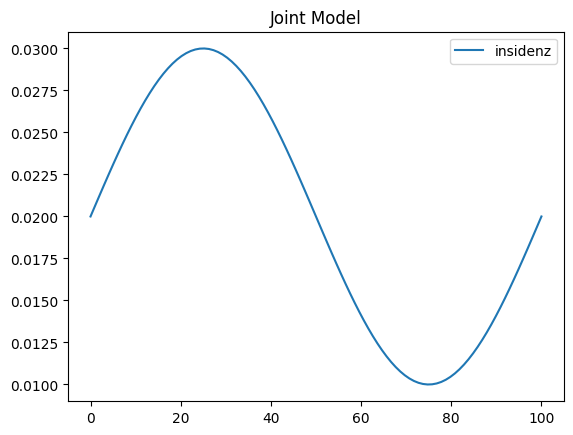

In [3]:
time = np.linspace(0, 100, 100)
plt.plot(time, insidenz(time), label='insidenz')
plt.title('Joint Model')
plt.legend()
plt.show()

# Estimation of the hazard function

In [4]:
class linearModel(NlmeBaseAmortizer):
    def __init__(self, name: str = 'myModel'):
        # define names of parameters
        param_names = ['intercept', 'slope', 'error-variance']

        # define prior values (for log-parameters)
        prior_mean = np.array([np.log(2500), -3, -2])
        prior_cov = np.diag([1, 1, 0.1])
        self.prior_type = 'normal'

        super().__init__(name=name,
                         param_names=param_names,
                         prior_mean=prior_mean,
                         prior_cov=prior_cov)

        self.simulator = Simulator(batch_simulator_fun=partial(self.batch_simulator))
        
    # define simulator
    @staticmethod
    def batch_simulator(param_batch: np.ndarray, time: Optional[np.ndarray] = None, 
                        maxtime: int = 100, with_noise: bool = True) -> np.ndarray:
        param_batch = np.exp(param_batch)

        if param_batch.ndim == 1:  # so not (batch_size, params)
            # just a single parameter set
            param_batch = param_batch[np.newaxis, :]

        if time is None:
            n_measurements = np.random.randint(1, 5)
            time = np.random.uniform(1, maxtime, n_measurements)
            time.sort()

        # simulate data
        y = np.zeros((param_batch.shape[0], time.size, 2))
        for p_id, params in enumerate(param_batch):
            # model plus noise
            y[p_id, :, 0] = params[0] * np.exp(-params[1] * time)
            if with_noise:
                y[p_id, :, 0] *= ( 1 + params[2] * np.random.normal(loc=0, scale=1, size=time.size))
            y[p_id, :, 1] = time / maxtime

        # add censoring
        y[:, :, 0] = np.log(np.clip(y[:, :, 0], a_min=0.001, a_max=2500))
        return y
        
    def load_amortizer_configuration(self, model_idx: int = 0, load_best: bool = False) -> str:
        self.n_epochs = 10
        bidirectional_LSTM = [False]
        n_coupling_layers = [2, 3]
        n_dense_layers_in_coupling = [2]
        coupling_design = ['affine']
        summary_network_type = ['sequence']

        combinations = list(itertools.product(bidirectional_LSTM, n_coupling_layers,
                                              n_dense_layers_in_coupling, coupling_design, summary_network_type))

        (self.bidirectional_LSTM,
         self.n_coupling_layers,
         self.n_dense_layers_in_coupling,
         self.coupling_design,
         self.summary_network_type) = combinations[model_idx]

        model_name = f'amortizer-toyModel-{self.prior_type}' \
                     f'-{self.summary_network_type}-summary' \
                     f'-{"Bi-LSTM" if self.bidirectional_LSTM else "LSTM"}' \
                     f'-{self.n_coupling_layers}layers' \
                     f'-{self.n_dense_layers_in_coupling}coupling-{self.coupling_design}' \
                     f'-{self.n_epochs}epochs'
        return model_name
        
    def plot_example(self, params: Optional[np.ndarray] = None) -> None:
        raise NotImplementedError('Not implemented yet.')
        
    def prepare_plotting(self, data: np.ndarray, params: np.ndarray, ax: Optional[plt.Axes] = None) -> plt.Axes:
        raise NotImplementedError('Not implemented yet.')

In [5]:
toy_model = linearModel()

using 2 layers of MultiConv1D, a  LSTM with 256 units and a dense layer with output dimension 10 as summary network
using a 3-layer cINN as inference network with 2 layers of design affine
prior mean: [ 7.82404601 -3.         -2.        ]
prior covariance diagonal: [1.  1.  0.1]


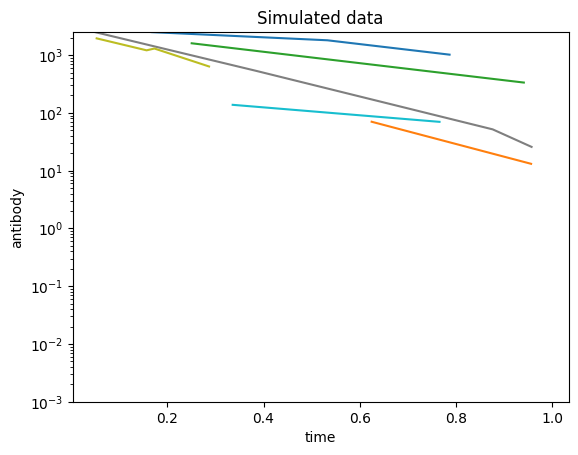

In [6]:
for i in range(10):
    prior_sample = toy_model.prior(1)['prior_draws']
    yt = toy_model.simulator(prior_sample)['sim_data']
    plt.plot(yt[0, :, 1], np.exp(yt[0, :, 0]))
plt.xlabel('time')
plt.ylabel('antibody')
plt.yscale('log')
plt.title('Simulated data')
plt.ylim(0.001, 2500)
plt.show()

In [7]:
trainer = toy_model.build_trainer('../networks/' + toy_model.network_name)

INFO:root:Performing 2 pilot runs with the myModel model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 3, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Loaded loss history from ../networks/amortizer-toyModel-normal-sequence-summary-LSTM-3layers-2coupling-affine-10epochs/history_104.pkl.
INFO:root:Networks loaded from ../networks/amortizer-toyModel-normal-sequence-summary-LSTM-3layers-2coupling-affine-10epochs/ckpt-104
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Model: "amortized_posterior"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  219702    
 ibleNetwork)                                                    
                                                                 
 sequence_network (Sequence  multiple                  306058    
 Network)                                                        
                                                                 
Total params: 525760 (2.01 MB)
Trainable params: 525742 (2.01 MB)
Non-trainable params: 18 (72.00 Byte)
_________________________________________________________________
None


In [8]:
new_sims = toy_model.generate_simulations_from_prior(trainer=trainer, n_samples=2500)
posterior_draws = toy_model.draw_posterior_samples(data=new_sims['summary_conditions'], n_samples=100)

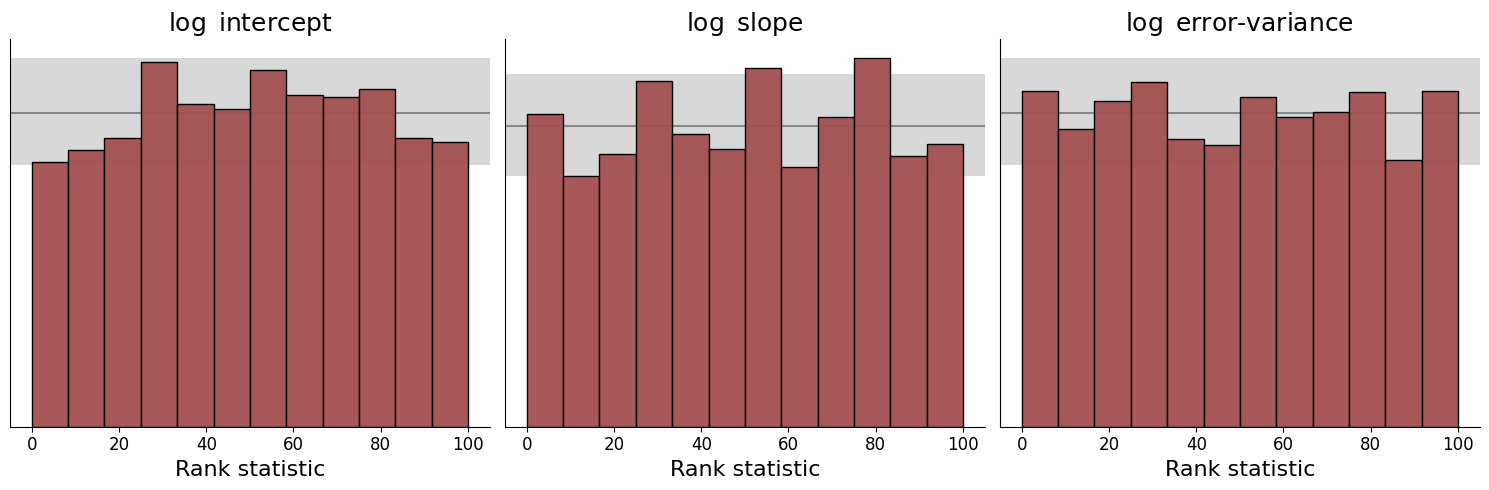

In [9]:
fig_sbc = diagnostics.plot_sbc_histograms(post_samples=posterior_draws,
                                          prior_samples=new_sims['parameters'],
                                          param_names=toy_model.log_param_names)

In [35]:
from inference.helper_functions import create_mixed_effect_model_param_names

np.random.seed(42)
toy_samples = toy_model.prior(100)['prior_draws']
toy_samples[:, -2:] = toy_model.prior_mean[-2:]
toy_data = toy_model.simulator(toy_samples)['sim_data']

mixed_effect_params_names = create_mixed_effect_model_param_names(toy_model.param_names, 
                                                                  cov_type='diag')
joint_model_names = mixed_effect_params_names + ['baseline_hazard', 'influence_antibody']

In [36]:
fixed_indices = np.array([4,5])
fixed_values = np.array([-np.log(0.001), -np.log(0.001)])

In [37]:
# generate data
np.random.seed(42)

linear_pars = 2200, 0.03
hazard_pars = 9, 0.4
random_variance = 1
error_variance = 0.1

def hazard_function(beta, t, log_ad_t):
    return beta[0] * insidenz(t) * ( 1 - expit(beta[1] * log_ad_t ))

In [38]:
def generate_data():
    re = np.exp(np.random.normal(0, random_variance))
    log_params = np.log(np.array([linear_pars[0]*re, linear_pars[1], error_variance]))
    random_start = np.random.randint(0, 75)
    time = np.linspace(random_start, 100, int(100-random_start))
    obs_data = toy_model.batch_simulator(log_params, time=time-random_start)[0]  # always start at 0
    
    # get hazard function
    h_obs = hazard_function(hazard_pars, time, obs_data[:, 0])
    # sample infection event
    infection_event = np.random.uniform(0, 1, len(h_obs)) < h_obs
    infection_event_index = next((i for i, x in enumerate(infection_event) if x), None)
    if infection_event_index is None:
        event_is_censored = True
        infection_event_index = len(infection_event) - 1
    else:
        event_is_censored = False
    # cut of data
    obs_data = obs_data[:infection_event_index]
    # maximum of 4 measurements
    m_index = np.random.choice(len(time[:infection_event_index]), min(4, len(time[:infection_event_index])), replace=False)
    m_index.sort()
    return log_params, obs_data[m_index], time[m_index], time[infection_event_index], event_is_censored, random_start

In [39]:
np.random.seed(42)
joint_model_obs = []
true_params = []
for i in range(100):
    log_params_i, obs_data_i, time_i, infection_event_i, event_i_is_censored, vaccine_date_i = generate_data()
    if obs_data_i.shape[0] == 0:
        continue
    joint_model_obs_i = {
    'obs_data': obs_data_i,
    'time': time_i,
    'infection_event': infection_event_i,
    'event_is_censored': event_i_is_censored,
    'vaccine_date': vaccine_date_i
    }
    true_params_i = {
        'log_params': log_params_i,
        'hazard_pars': hazard_pars
    }
    joint_model_obs.append(joint_model_obs_i)
    true_params.append(true_params_i)
print(len(joint_model_obs))

100


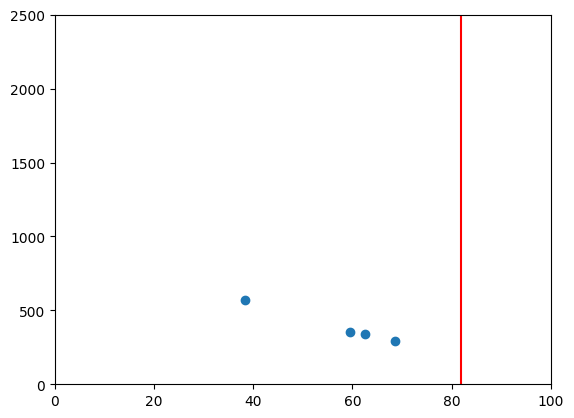

In [40]:
plt.scatter(time_i, np.exp(obs_data_i[:, 0]), label='antibody')
plt.xlim(0,100)
plt.ylim(0,2500)
plt.vlines(infection_event_i, ymin=0, ymax=2500, color='r')
plt.show()

In [41]:
def log_hazard_term(evet_time_i, event_i_is_censored, hazard_pars, log_mixed_pars, batch_simulator):
    
    h_func = lambda t: float(hazard_function(hazard_pars, t, 
                                             log_ad_t=batch_simulator(log_mixed_pars, 
                                                             time=np.array([t]), 
                                                             with_noise=False)[0, :, 0]
                                             )
                             )
    integrand, err = integrate.quad(h_func, 0, evet_time_i)
    s = np.exp(-integrand)
    
    if event_i_is_censored:
        return np.log(s)
    else:
        return np.log(s * float(h_func(evet_time_i)))

In [42]:
def compute_hazard(param_samples: np.ndarray, joint_params: np.ndarray, 
                   joint_model_dict: list[dict], batch_simulator: callable) -> np.ndarray:
    n_sim, n_samples, _ = param_samples.shape
    res = np.zeros((n_sim, n_samples))
    
    for ns in range(n_sim):
        infection_event_time_i = joint_model_dict[ns]['infection_event']
        event_i_is_censored = joint_model_dict[ns]['event_is_censored']
        vaccine_date_i = joint_model_dict[ns]['vaccine_date']
        
        for ps in range(n_samples):
            def h_func(t):
                sim = batch_simulator(
                    param_batch=param_samples[ns, ps],
                    time=np.array([t - vaccine_date_i]), 
                    with_noise=False)[0, :, 0]
                return np.exp(joint_params[0]) * insidenz(t) * ( 1 - expit(np.exp(joint_params[1]) * sim))
            # using gaussian quadrature
            integrand, err = integrate.fixed_quad(h_func, vaccine_date_i, infection_event_time_i, n=5)
            # integrate.quad would be a general purpose integrator 

            s = np.exp(-integrand)
            
            if event_i_is_censored:
                res[ns, ps] = np.log(s)
            else:
                res[ns, ps] = np.log(s * float(h_func(infection_event_time_i)))
    return res

compute_hazard_helper = partial(compute_hazard, 
                                joint_model_dict=joint_model_obs, batch_simulator=toy_model.batch_simulator)

In [ ]:
from inference.inference_functions import run_population_optimization

result_optimization, obj_fun_amortized = run_population_optimization(
    individual_model=toy_model,
    data=[item['obs_data'] for item in joint_model_obs],
    param_names=joint_model_names,
    cov_type='diag',
    n_multi_starts=10,
    n_samples_opt=50,
    covariates_bounds=None,
    covariates=None,
    n_covariates_params=0,
    covariate_mapping=None,
    n_joint_params=len(hazard_pars),
    joint_model_bounds=np.array([[np.log(0.001), np.log(15)], [np.log(0.001), 0]]),
    #joint_model_obs=joint_model_obs, 
    joint_model_term=compute_hazard_helper,
    x_fixed_indices=fixed_indices,
    x_fixed_vals=fixed_values,
    file_name=None,  # f'../output/{model_name}-{cov_type}-n_data_{n_data}.hdf5',
    verbose=True,
    trace_record=True,
    pesto_multi_processes=10,
    result=None  #result_optimization
)

Multi-start optimization:   0%|          | 0/1 [00:00<?, ?it/s]

                               free   lb_full    ub_full
pop-intercept                  True  4.824046  10.824046
pop-slope                      True -6.000000   0.000000
pop-error-variance             True -2.948683  -1.051317
$-\log$ (var-intercept)        True -2.741328   3.258672
$-\log$ (var-slope)           False -2.741328   3.258672
$-\log$ (var-error-variance)  False -2.741328   3.258672
baseline_hazard                True -6.907755   2.708050
influence_antibody             True -6.907755   0.000000
                              fixed value
$-\log$ (var-slope)              6.907755
$-\log$ (var-error-variance)     6.907755



  0%|          | 0/10 [00:00<?, ?it/s]

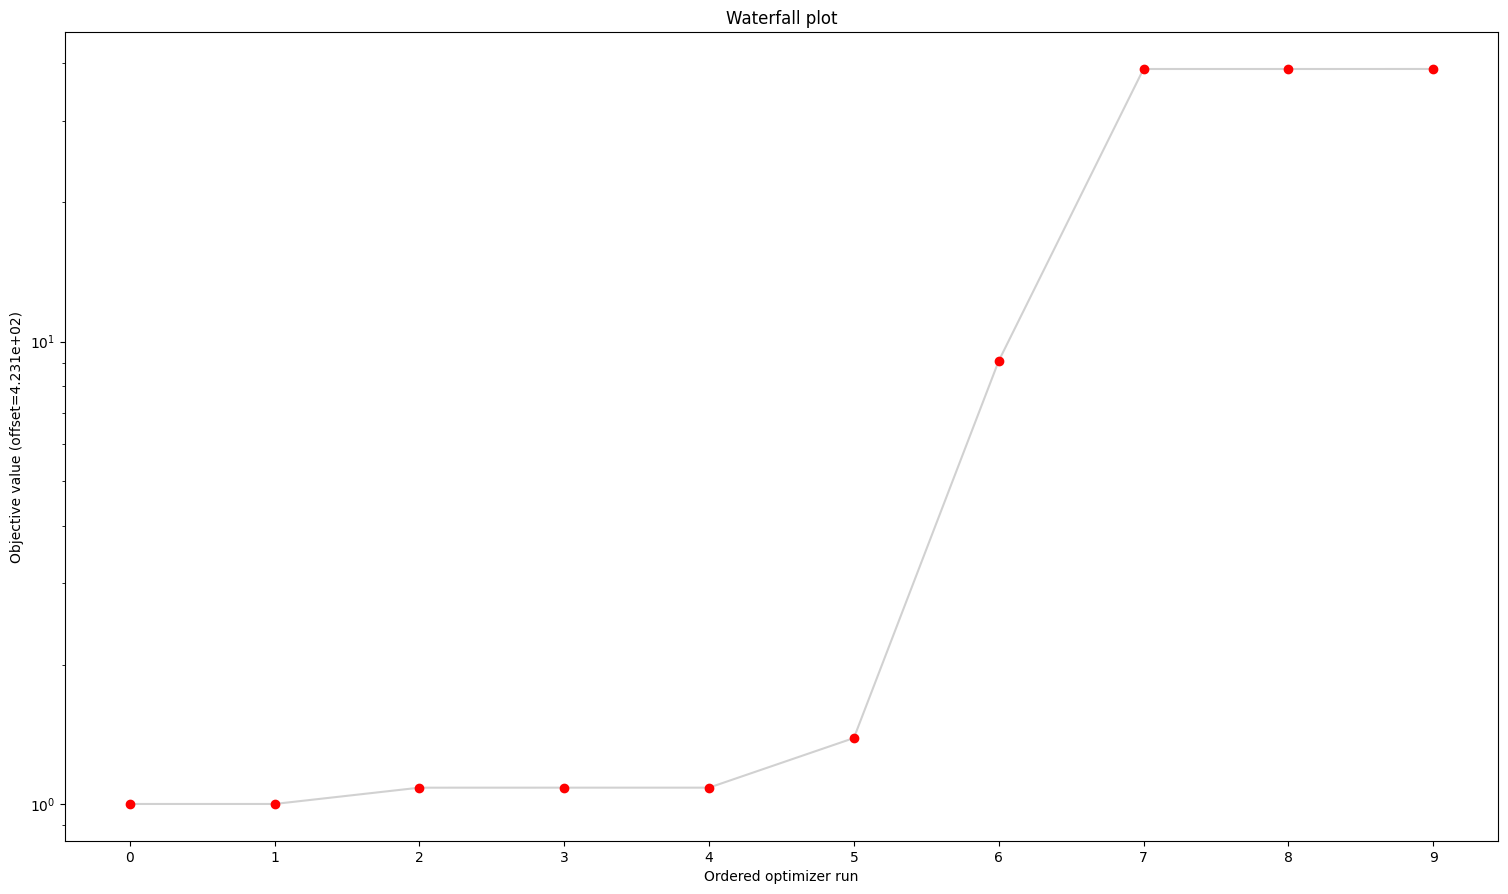

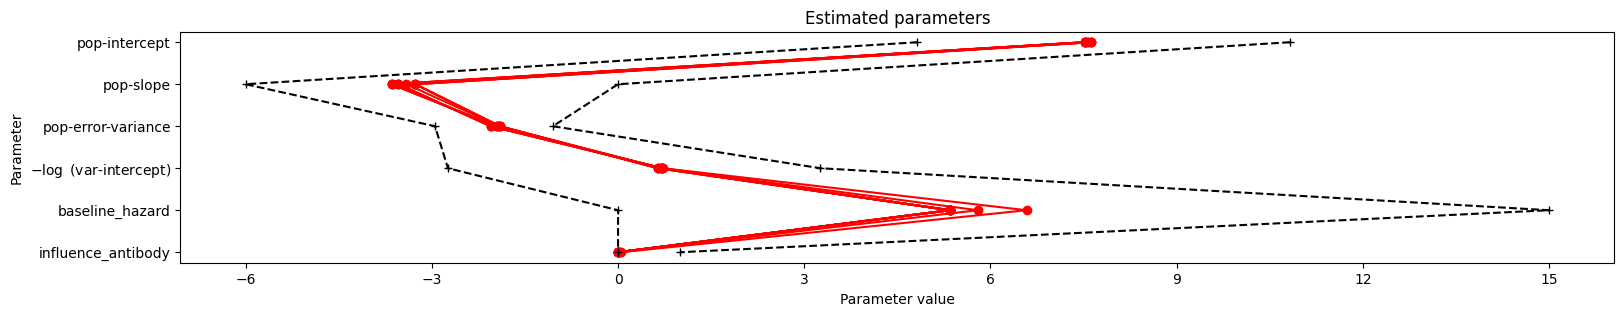

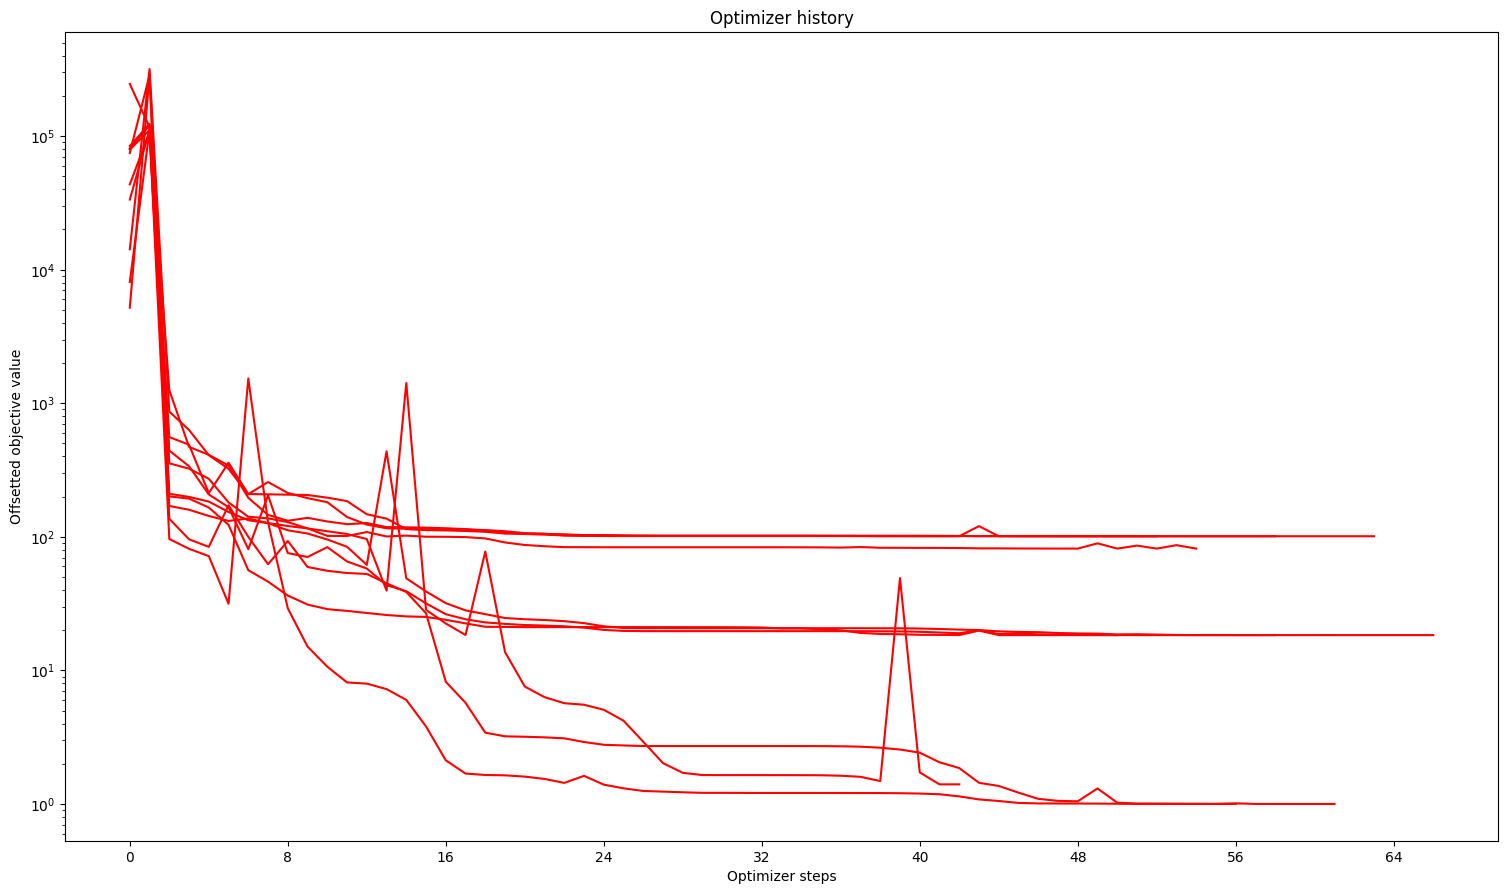

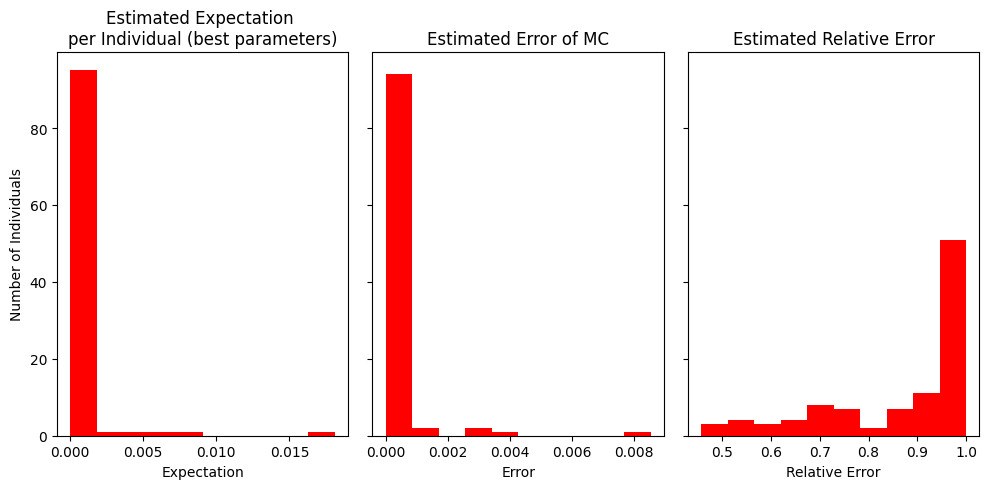

In [21]:
visualize_pesto_result(result_optimization, use_batch_coloring=True, obj_fun_amortized=obj_fun_amortized)

In [22]:
estimate = np.concatenate((result_optimization.optimize_result.x[0][:3], np.exp(-result_optimization.optimize_result.x[0][3:6]), result_optimization.optimize_result.x[0][6:]))

full_params = np.stack([param['log_params'] for param in true_params])
test_val = np.concatenate((np.mean(full_params, axis=0), np.var(full_params, axis=0), hazard_pars))
test_val[np.abs(test_val) < 1e-8] = 0.001

In [24]:
pd.DataFrame(estimate.round(5), index=joint_model_names)

,0
pop-intercept,7.53041
pop-slope,-3.53752
pop-error-variance,-2.05089
var-intercept,0.49155
var-slope,0.00100
var-error-variance,0.00100
baseline_hazard,5.34862
influence_antibody,0.00000


In [23]:
pd.DataFrame(((estimate-test_val)**2/(test_val**2)).round(5), index=joint_model_names)

,0
pop-intercept,0.00027
pop-slope,0.00008
pop-error-variance,0.01195
var-intercept,0.31011
var-slope,0.00000
var-error-variance,0.00000
baseline_hazard,0.10984
influence_antibody,1.00000
